In [15]:
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
db_user = ""
db_password = ""
db_host = ""  
db_port = "" 
db_name = ""
connection = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(connection)

In [27]:
query= text("SELECT DATE(datefrom) AS date, toid, SUM(datavalue) AS datavalue FROM movements GROUP BY date, toid ORDER BY date;")
try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query, connection, chunksize=1000) 
        df = pd.concat(chunks, ignore_index=True) 
    print(df)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

             date                toid  datavalue
0      2019-08-01  08|033|001|000|000       3649
1      2019-08-01  08|033|002|000|000       7193
2      2019-08-01  08|033|003|000|000       2245
3      2019-08-01  08|033|004|000|000       6263
4      2019-08-01  08|033|005|000|000       3571
...           ...                 ...        ...
28543  2019-09-30  08|099|024|000|000       4078
28544  2019-09-30  08|099|025|000|000      10383
28545  2019-09-30  08|099|026|000|000       2919
28546  2019-09-30  08|099|027|000|000       2315
28547  2019-09-30  08|099|999|000|255      55142

[28548 rows x 3 columns]


In [28]:
from sklearn.preprocessing import LabelEncoder
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df["weekday"] = df["date"].dt.weekday
df["week"] = df["date"].dt.isocalendar().week - df["date"].dt.isocalendar().week.min()
df['weekend'] = df['weekday'].apply(lambda w: 1  if (w == 5 or w == 6) else 0)

df['festivo'] = ((df['week'].isin([1, 2])) | (df['weekday'].isin([5, 6]))).astype(int)

# Aggiunta: flag mese (agosto=0, settembre=1)
df["month"] = df["date"].dt.month.map({8: 0, 9: 1})

for lag in [1, 2, 3, 7]:
    df[f'lag_{lag}'] = df['datavalue'].shift(lag)
# sostituisco i NaN con 0 
df[['lag_1', 'lag_2', 'lag_3', 'lag_7']] = df[['lag_1', 'lag_2', 'lag_3', 'lag_7']].fillna(0)

#df["date"] = df['date'].astype('int64') #RENDIAMO DATA NUMERICO

df

,date,toid,datavalue,weekday,week,weekend,festivo,month,lag_1,lag_2,lag_3,lag_7
0,2019-08-01,08|033|001|000|000,3649,3,0,0,0,0,0.0,0.0,0.0,0.0
1,2019-08-01,08|033|002|000|000,7193,3,0,0,0,0,3649.0,0.0,0.0,0.0
2,2019-08-01,08|033|003|000|000,2245,3,0,0,0,0,7193.0,3649.0,0.0,0.0
3,2019-08-01,08|033|004|000|000,6263,3,0,0,0,0,2245.0,7193.0,3649.0,0.0
4,2019-08-01,08|033|005|000|000,3571,3,0,0,0,0,6263.0,2245.0,7193.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
28543,2019-09-30,08|099|024|000|000,4078,0,9,0,0,1,7163.0,2730.0,1385.0,15051.0
28544,2019-09-30,08|099|025|000|000,10383,0,9,0,0,1,4078.0,7163.0,2730.0,30107.0
28545,2019-09-30,08|099|026|000|000,2919,0,9,0,0,1,10383.0,4078.0,7163.0,7342.0
28546,2019-09-30,08|099|027|000|000,2315,0,9,0,0,1,2919.0,10383.0,4078.0,14025.0


In [31]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Definizione dei 3 set di feature da confrontare
feature_sets = {
    "set1": ['date_ns', 'toid', 'weekday', 'weekend', 'week'],
    "set2": ['date_ns', 'toid', 'festivo', 'month'],
    "set3": ['date_ns', 'toid', 'lag_1', 'lag_2', 'lag_3', 'lag_7']
}

# Per ciascun set memorizziamo una lista di MAPE
results = {key: [] for key in feature_sets.keys()}

seed = 42

# Codifica numerica dei toid 
le = LabelEncoder()
df['toid'] = le.fit_transform(df['toid'])


# Convertiamo 'date' in timestamp int64 per il modello
df['date_ns'] = df['date'].astype('int64')

unique_dates = sorted(df["date"].dt.date.unique())

# Selezione primi 41 giorni per il training, ultimi 20 per il test
train_dates = unique_dates[:41]
test_dates = unique_dates[-20:]

for set_name, features in feature_sets.items():
    # Separazione train/test su base temporale
    train_df = df[df["date"].dt.date.isin(train_dates)]
    test_df = df[df["date"].dt.date.isin(test_dates)]

    X_train = train_df[features]
    y_train = train_df["datavalue"]

    # Normalizzazione
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Log-transform target
    y_train_scaled = np.log1p(y_train)

    # Modello e iperparametri
    model = GradientBoostingRegressor(random_state=seed)
    param_grid = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }

    grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1, verbose=0)
    grid.fit(X_train_scaled, y_train_scaled)

    best_model = grid.best_estimator_

    # Ora per ogni toid nel test set, facciamo la previsione
    for toid in test_df["toid"].unique():
        df_toid_test = test_df[test_df["toid"] == toid]
        X_test = df_toid_test[features]
        y_test = df_toid_test["datavalue"]

        X_test_scaled = scaler.transform(X_test)
        y_test_scaled = np.log1p(y_test)

        y_pred_scaled = best_model.predict(X_test_scaled)
        y_pred = np.expm1(y_pred_scaled)
        y_test_orig = np.expm1(y_test_scaled)

        mape = mean_absolute_percentage_error(y_test_orig, y_pred)
        results[set_name].append((toid, mape))

results_df = pd.DataFrame([
    {'feature_set': set_name, 'toid': toid, 'mape': mape}
    for set_name, toid_mape_list in results.items()
    for toid, mape in toid_mape_list
])


# Calcolo del MAPE medio per ciascun set di feature
mape_medio_per_set = results_df.groupby('feature_set')['mape'].mean()

# Stampa in ordine crescente di errore
print("MAPE medio per ciascun set di feature:")
print(mape_medio_per_set.sort_values())

MAPE medio per ciascun set di feature:
feature_set
set1    0.104467
set2    0.107653
set3    0.156868
Name: mape, dtype: float64


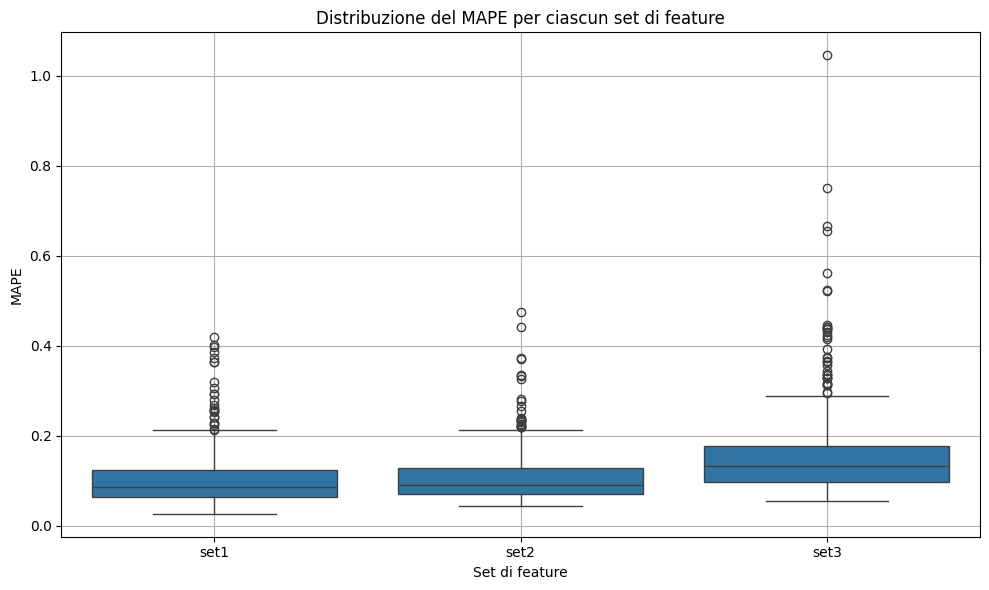

In [35]:
import seaborn as sns

# Boxplot della distribuzione del MAPE per ogni set di feature
plt.figure(figsize=(10, 6))
sns.boxplot(x="feature_set", y="mape", data=results_df)
plt.title("Distribuzione del MAPE per ciascun set di feature")
plt.ylabel("MAPE")
plt.xlabel("Set di feature")
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
print("🏆 Top 10 toid con MAPE più basso (su tutti i modelli):")
print(results_df.sort_values('mape').head(10))


🏆 Top 10 toid con MAPE più basso (su tutti i modelli):
    feature_set  toid      mape
238        set1   238  0.026448
7          set1     7  0.032362
223        set1   223  0.034344
316        set1   316  0.035098
417        set1   417  0.035626
156        set1   156  0.037124
146        set1   146  0.038626
138        set1   138  0.038846
119        set1   119  0.040021
455        set1   455  0.041499


In [39]:
print("❌ Worst 10 toid con MAPE più alto (su tutti i modelli):")
print(results_df.sort_values('mape', ascending=False).head(10))


❌ Worst 10 toid con MAPE più alto (su tutti i modelli):
     feature_set  toid      mape
988         set3    52  1.045262
952         set3    16  0.750525
1337        set3   401  0.665080
1012        set3    76  0.654889
944         set3     8  0.561604
950         set3    14  0.523411
974         set3    38  0.522261
544         set2    76  0.475612
1000        set3    64  0.445448
497         set2    29  0.441695
